In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

from bs4 import BeautifulSoup
import re,string,unicodedata

from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation

import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

## **Step 1: Read and explore the data**

In [ ]:
path='/content/gdrive/MyDrive/Data - Sarcasm Detection./Sarcasm_Headlines_Dataset.json'

In [ ]:
#another way to read data in json
import json
rows = []
for line in open(path, 'r'):
    rows.append(json.loads(line))

In [ ]:
df = pd.read_json(path, lines=True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
df.isna().sum() # Checking for NaN values

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [ ]:
df.isnull().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [ ]:
df.columns

Index(['article_link', 'headline', 'is_sarcastic'], dtype='object')

In [ ]:
df.shape

(26709, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


## **Analyzing the data**

 **Checking if Data is Balanced**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


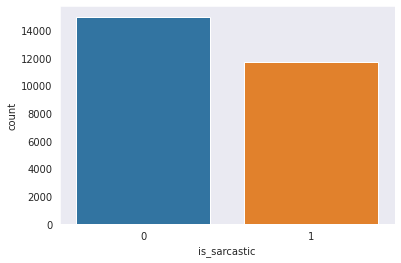

In [ ]:
sns.set_style("dark");
sns.countplot(df.is_sarcastic);

So, we can see that the dataset is balanced.

## **WordCloud for text that is NOT Sarcastic (LABEL - 0)**

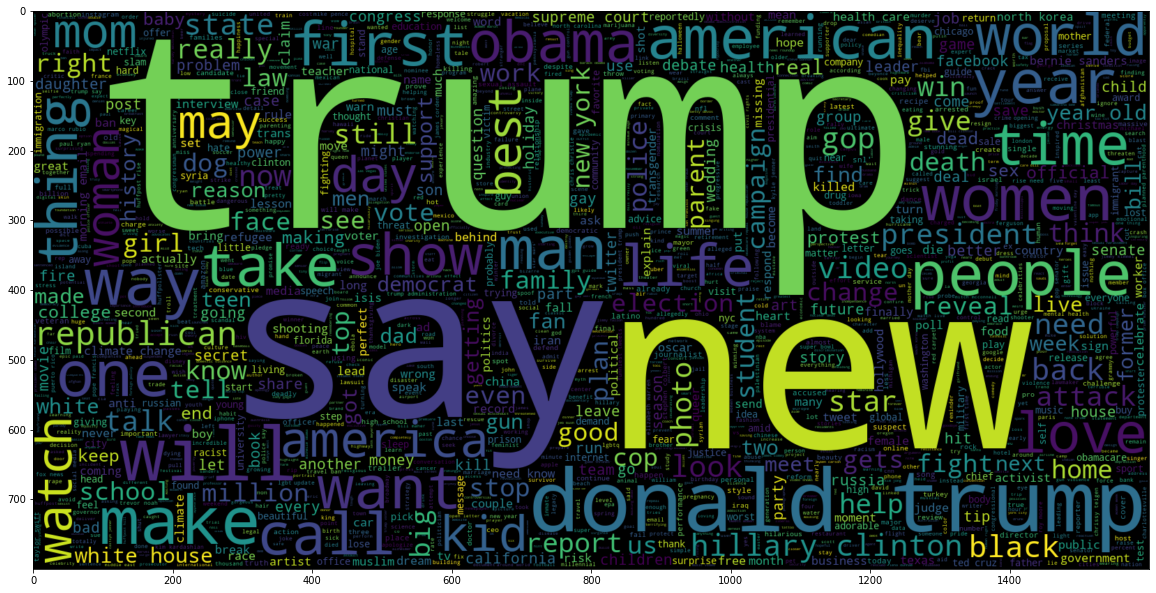

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

## **WordCloud  for Sarcastic text (LABEL - 1)**

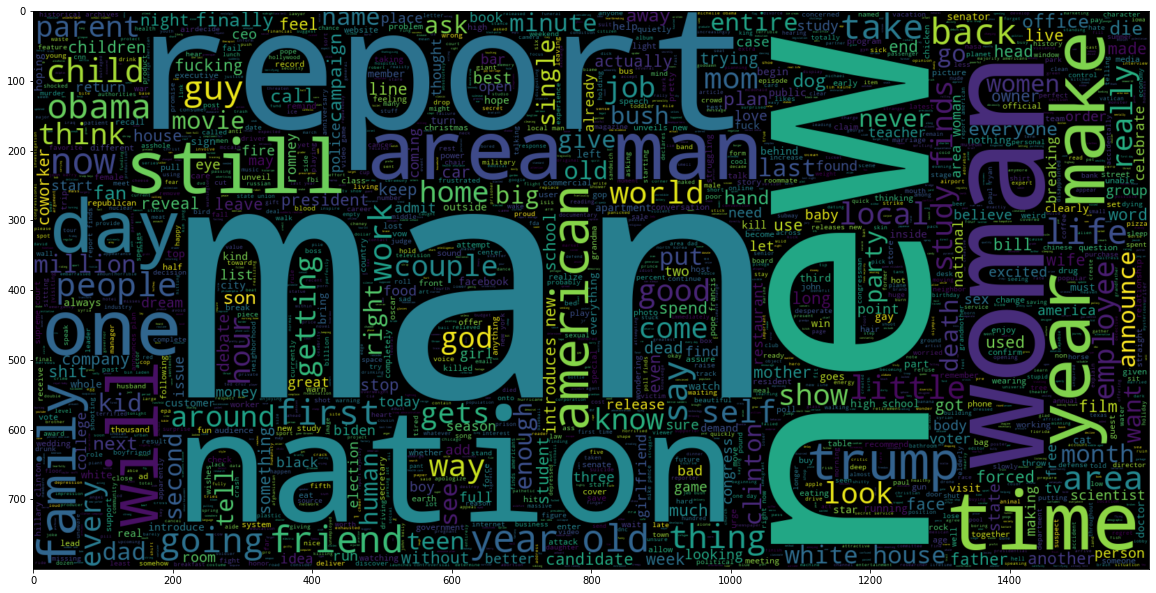

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

## **Number of characters in texts**

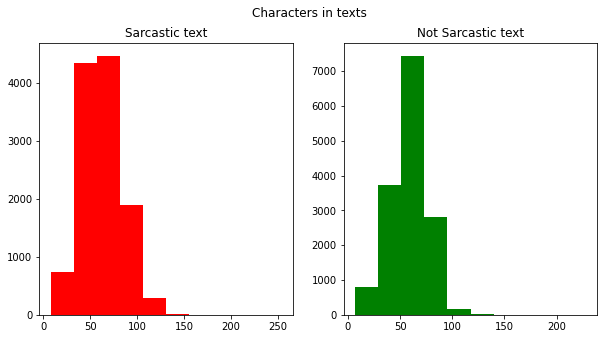

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

## **Number of words in each text**

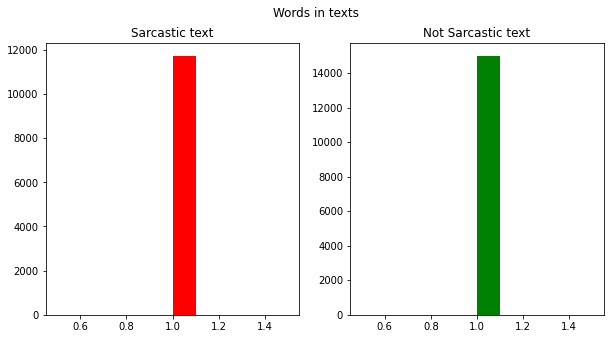

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

## **Average word length in a text**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each text')

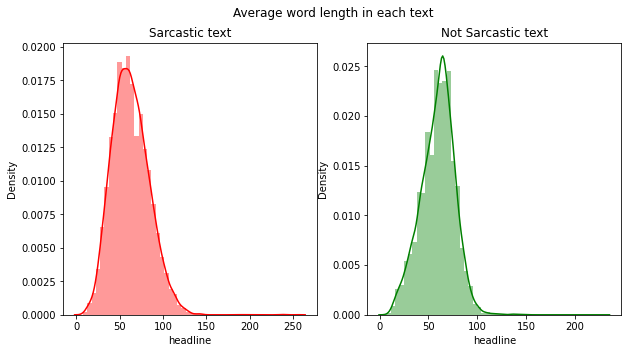

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

## **Step 2: Retain relevant columns**

In [ ]:
del df['article_link'] # Deleting this column as it is of no use

In [ ]:
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


## **Step 3: Get length of each sentence**

In [ ]:
df.sample(5)

,headline,is_sarcastic
16906,the best place to buy designer fall clothes on...,0
22149,area man gets in one last night of sex before ...,1
6132,building the university of the future,0
15041,self-conscious panda swears it overheard zooke...,1
12155,the importance of multidisciplinary eating dis...,0


In [ ]:
length=[len(s) for s in df['headline']]

In [ ]:
len(length)

26709

In [ ]:
print("Length of first 10 sentences is",length[:10])

Length of first 10 sentences is [78, 84, 79, 84, 64, 27, 46, 67, 50, 59]


In [ ]:
print("Mean of sentence lengths is: ", np.mean(length))
print("Standard Deviation of sentence lengths is: ", np.std(length))

Mean of sentence lengths is:  60.910591935302705
Standard Deviation of sentence lengths is:  19.18411115197181


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

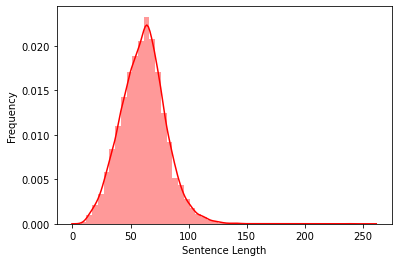

In [ ]:
#Histogram for sentences length
sns.distplot(length,color='red');
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")

## **Step 4: Define parameters**

Done after Step 6 below

## **Basic Data Processing**

**Converting to Lower case**

In [ ]:
df['headline'] = df['headline'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['headline'].head()

0    former versace store clerk sues over secret 'b...
1    the 'roseanne' revival catches up to our thorn...
2    mom starting to fear son's web series closest ...
3    boehner just wants wife to listen, not come up...
4    j.k. rowling wishes snape happy birthday in th...
Name: headline, dtype: object

 **Removal of Punctuation**

In [ ]:
df['headline'] = df['headline'].str.replace('[^\w\s]','') 
#Replace any character that is not a word character or a space character with nothing.
df['headline'].head() #[^a-zA-Z\s]

0    former versace store clerk sues over secret bl...
1    the roseanne revival catches up to our thorny ...
2    mom starting to fear sons web series closest t...
3    boehner just wants wife to listen not come up ...
4    jk rowling wishes snape happy birthday in the ...
Name: headline, dtype: object

 **Removal of Stop Words**

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [ ]:
df['headline'] = df['headline'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['headline'].head()

0    former versace store clerk sues secret black c...
1    roseanne revival catches thorny political mood...
2    mom starting fear sons web series closest thin...
3    boehner wants wife listen come alternative deb...
4    jk rowling wishes snape happy birthday magical...
Name: headline, dtype: object

 **Lemmatization**

In [ ]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

df['headline']= df['headline'].apply(lambda x: " ".join([lemma.lemmatize(x) for x in x.split()]))
df['headline'].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


0    former versace store clerk sue secret black co...
1    roseanne revival catch thorny political mood b...
2    mom starting fear son web series closest thing...
3    boehner want wife listen come alternative debt...
4     jk rowling wish snape happy birthday magical way
Name: headline, dtype: object

## **Step 5: Get indices for words**

In [ ]:
from string import punctuation
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('punkt')
import numpy as np
import re

stop_words = stopwords.words('english') + list(punctuation)
 
def tokenize(text):
    words = word_tokenize(text)
    words = [w.lower() for w in words]
    return [w for w in words if w not in stop_words and not w.isdigit()]

words = list()
for comp in df['headline']:
    for w in tokenize(comp):
        words.append(w)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
words[:20]

['former',
 'versace',
 'store',
 'clerk',
 'sue',
 'secret',
 'black',
 'code',
 'minority',
 'shopper',
 'roseanne',
 'revival',
 'catch',
 'thorny',
 'political',
 'mood',
 'better',
 'worse',
 'mom',
 'starting']

In [ ]:
words2index = {w:i for i,w in enumerate(words)}

186032

In [ ]:
words2index.get('basic')

186032

In [ ]:
words2index.get('catch')

178596

In [ ]:
words2index.get('wife')

183540

## **Step 7: Get vocabulary size**

In [ ]:
words.append('dummy')
n_words = len(words)
print("Size of vocabulary is",n_words)

Size of vocabulary is 186083


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
MAX_NB_WORDS = 20000
t = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None, document_count=0)
t.fit_on_texts(df['headline'])

In [ ]:
vocab_size = n_words
# load the whole embedding into memory
embeddings_index = dict()

 **Importing Glove Embeddings**

In [ ]:
f = open('/content/gdrive/MyDrive/Data - Sarcasm Detection./glove.6B.200d.txt')

In [ ]:
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


## **Step 8: Create a weight matrix using GloVe embeddings**

In [ ]:
embedding_matrix = np.zeros((vocab_size, 200))

In [ ]:
vocab_size

186083

In [ ]:
maxlen = 200

In [ ]:
t.index_word.get(3000)

'prep'

In [ ]:
t.word_index.items()

dict_items([('trump', 1), ('new', 2), ('man', 3), ('woman', 4), ('say', 5), ('report', 6), ('get', 7), ('u', 8), ('one', 9), ('day', 10), ('make', 11), ('american', 12), ('year', 13), ('area', 14), ('time', 15), ('donald', 16), ('like', 17), ('life', 18), ('first', 19), ('people', 20), ('way', 21), ('world', 22), ('nation', 23), ('house', 24), ('thing', 25), ('obama', 26), ('show', 27), ('take', 28), ('clinton', 29), ('still', 30), ('family', 31), ('back', 32), ('white', 33), ('find', 34), ('child', 35), ('want', 36), ('state', 37), ('could', 38), ('school', 39), ('call', 40), ('know', 41), ('right', 42), ('need', 43), ('mom', 44), ('gop', 45), ('black', 46), ('study', 47), ('kid', 48), ('bill', 49), ('go', 50), ('5', 51), ('president', 52), ('love', 53), ('look', 54), ('watch', 55), ('friend', 56), ('america', 57), ('would', 58), ('home', 59), ('best', 60), ('police', 61), ('death', 62), ('parent', 63), ('plan', 64), ('really', 65), ('star', 66), ('cant', 67), ('good', 68), ('video', 

In [ ]:
leftwords=[]
for word, i in t.word_index.items():
    #if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
      
      embedding_matrix[i] = embedding_vector
    else:
      leftwords.append(word)
      

In [ ]:
print("Total words which were not found in glove embeddings are",len(leftwords),"out of total",vocab_size," words\n")
print("Some words which were not found in Glove embeddings(Spelling mistake, No space between 2 words)\n",leftwords[1:11])

Total words which were not found in glove embeddings are 3589 out of total 186083  words

Some words which were not found in Glove embeddings(Spelling mistake, No space between 2 words)
 ['huffpollster', 'youve', 'samesex', 'reallife', '5yearold', '7yearold', 'lastminute', 'nsfw', '8yearold', '4yearold']


In [ ]:
embedding_matrix.shape

(186083, 200)

In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.80177999,  0.16873001,  0.17636   , ...,  0.70449001,
         0.46037999, -0.26025   ],
       [-0.13451999,  0.42318001, -0.20051999, ..., -0.0091233 ,
         0.31496999,  0.47435999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

# **Step 6: Create features and labels**

In [ ]:
features=df.headline
labels=df.is_sarcastic

TRAIN TEST SPLIT

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(df.headline,df.is_sarcastic, test_size = 0.3 , random_state = 0)

In [ ]:
max_features = 35000
maxlen = 200

 **Tokenizing Text**

Mapping of orginal word to number is preserved in word_index property of tokenizer

Tokenized applies basic processing like changing it to lower case, explicitely setting that as False



In [ ]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)

In [ ]:
tokenized_train = tokenizer.texts_to_sequences(x_train)

 **Keeping all news to 200, add padding to news with less than 200 words and truncating long ones**

In [ ]:
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

Repeating for test data

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

## **Step 4: Define parameters**

In [ ]:
max_features = 35000
maxlen = 200

embed_size = 200 

nb_words=186083 

batch_size = 128 
epochs = 10

## **Step 9: Define and compile a Bidirectional LSTM model**

TRAINING GLOVE EMBEDDINGS MODEL

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(nb_words, output_dim=embed_size, weights=[embedding_matrix], input_length=200, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5)))
model.add(Dense(1, activation='sigmoid'))


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 200)          37216600  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               336896    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 37,553,753
Trainable params: 37,553,753
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## **Step 10: Fit the model and check the validation accuracy**

In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 10)

Epoch 1/10
147/147 [==============================] - 312s 2s/step - loss: 0.6573 - acc: 0.6072 - val_loss: 0.4615 - val_acc: 0.7837
Epoch 2/10
147/147 [==============================] - 278s 2s/step - loss: 0.3049 - acc: 0.8766 - val_loss: 0.4794 - val_acc: 0.7988
Epoch 3/10
147/147 [==============================] - 277s 2s/step - loss: 0.1289 - acc: 0.9552 - val_loss: 0.6303 - val_acc: 0.7908
Epoch 4/10
147/147 [==============================] - 278s 2s/step - loss: 0.0719 - acc: 0.9758 - val_loss: 0.8171 - val_acc: 0.7897
Epoch 5/10
147/147 [==============================] - 279s 2s/step - loss: 0.0388 - acc: 0.9866 - val_loss: 1.0241 - val_acc: 0.7876
Epoch 6/10
147/147 [==============================] - 283s 2s/step - loss: 0.0260 - acc: 0.9912 - val_loss: 1.1892 - val_acc: 0.7853
Epoch 7/10
147/147 [==============================] - 285s 2s/step - loss: 0.0199 - acc: 0.9929 - val_loss: 1.2761 - val_acc: 0.7868
Epoch 8/10
147/147 [==============================] - 284s 2s/step - 

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)

585/585 [==============================] - 53s 90ms/step - loss: 0.0032 - acc: 0.9987
Accuracy of the model on Training Data is -  99.86628293991089


In [ ]:
print("Accuracy of the model on Validation Data is - " , model.evaluate(X_test,y_test)[1]*100)

251/251 [==============================] - 23s 90ms/step - loss: 1.5990 - acc: 0.7804
Accuracy of the model on Validation Data is -  78.03569436073303


## **Model Prediction and Performance**

In [ ]:
pred = model.predict_classes(X_test)
pred[:5]

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1],
       [0],
       [1],
       [0],
       [1]], dtype=int32)

In [ ]:
print(classification_report(y_test, pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.79      0.83      0.81      4483
    Sarcastic       0.77      0.71      0.74      3530

     accuracy                           0.78      8013
    macro avg       0.78      0.77      0.78      8013
 weighted avg       0.78      0.78      0.78      8013



In [ ]:
cm = confusion_matrix(y_test,pred)
cm

array([[3730,  753],
       [1007, 2523]])

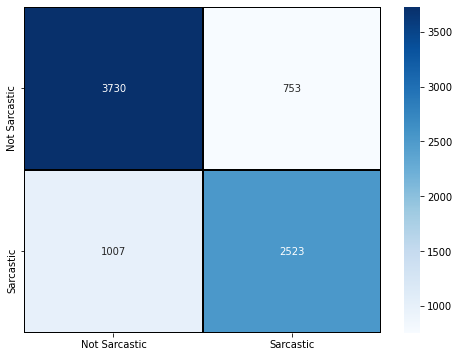

In [ ]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (8,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , 
            xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

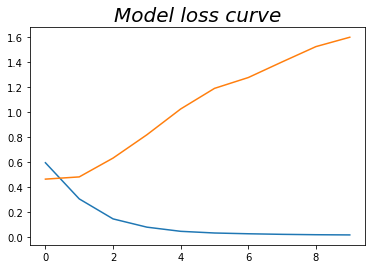

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss curve',fontdict={'size':20,'style':'italic'})
plt.show()

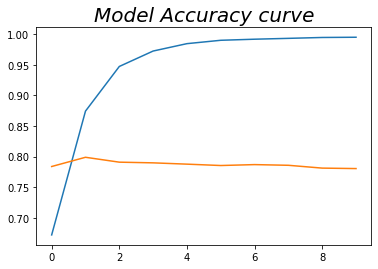

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy curve',fontdict={'size':20,'style':'italic'})
plt.show()

 **Here it is evident that our model works quite well with train accuracy of 99.86% and test accuracy of about 85%.Thus model could be used for sarcasm detection.**